In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [91]:
# Data Loading and Initial Inspection

In [5]:
df = pd.read_csv("C:/Users/Shivprasad/Downloads/covid_19_data.csv")
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306429 entries, 0 to 306428
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SNo              306429 non-null  int64  
 1   ObservationDate  306429 non-null  object 
 2   Province/State   228326 non-null  object 
 3   Country/Region   306429 non-null  object 
 4   Last Update      306429 non-null  object 
 5   Confirmed        306429 non-null  float64
 6   Deaths           306429 non-null  float64
 7   Recovered        306429 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 18.7+ MB


In [9]:
df.describe()

,SNo,Confirmed,Deaths,Recovered
count,306429.000000,3.064290e+05,306429.000000,3.064290e+05
mean,153215.000000,8.567091e+04,2036.403268,5.042029e+04
std,88458.577156,2.775516e+05,6410.938048,2.015124e+05
min,1.000000,-3.028440e+05,-178.000000,-8.544050e+05
25%,76608.000000,1.042000e+03,13.000000,1.100000e+01
50%,153215.000000,1.037500e+04,192.000000,1.751000e+03
75%,229822.000000,5.075200e+04,1322.000000,2.027000e+04
max,306429.000000,5.863138e+06,112385.000000,6.399531e+06


In [11]:
df.isna().sum()

SNo                    0
ObservationDate        0
Province/State     78103
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64

In [13]:
df.shape

(306429, 8)

In [ ]:
# Handle Missing Values
# Method 1: Dropping rows with missing values

In [15]:
new_df = df.dropna()
new_df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [17]:
new_df.shape

(228326, 8)

In [ ]:
# Method 2: Imputation (Numerical with mean, Categorical with most frequent)

In [19]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include='object').columns
df_imputed = df.copy()
num_imputer = SimpleImputer(strategy='mean')
df_imputed[num_cols] = num_imputer.fit_transform(df[num_cols])

# Impute categorical columns with most frequent value (mode)
cat_imputer = SimpleImputer(strategy='most_frequent')
df_imputed[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
df_imputed.isna().sum()

SNo                0
ObservationDate    0
Province/State     0
Country/Region     0
Last Update        0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64

In [ ]:
# Detect and Treat Outliers
# Method 1: IQR (Interquartile Range) Method

In [23]:
numeric_cols = df_imputed.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    Q1 = df_imputed[col].quantile(0.25)
    Q3 = df_imputed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_imputed[(df_imputed[col] < lower_bound) | (df_imputed[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")

SNo: 0 outliers
Confirmed: 43978 outliers
Deaths: 42102 outliers
Recovered: 46463 outliers


In [25]:
df_iqr_removed = df_imputed.copy()
df_iqr_removed = df_iqr_removed[(df_iqr_removed[col] >= lower_bound) & (df_iqr_removed[col] <= upper_bound)]
print("✅ Shape after IQR outlier removal:", df_iqr_removed.shape)

✅ Shape after IQR outlier removal: (259966, 8)


In [ ]:
# Method 2: Z-score Method

In [27]:
z_scores = np.abs(zscore(df_imputed[numeric_cols]))
threshold = 3

outlier_rows = (z_scores > threshold).any(axis=1)
print("Number of outliers (Z-score method):", outlier_rows.sum())

Number of outliers (Z-score method): 8297


In [29]:
df_z_removed = df_imputed[~outlier_rows]
print("Shape after Z-score outlier removal:", df_z_removed.shape)

Shape after Z-score outlier removal: (298132, 8)


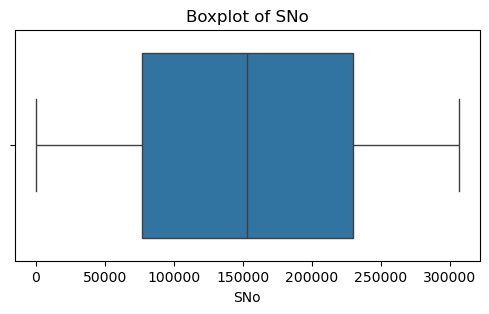

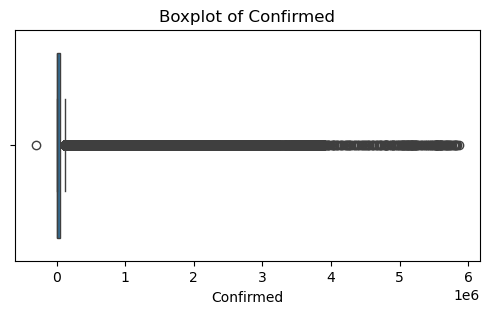

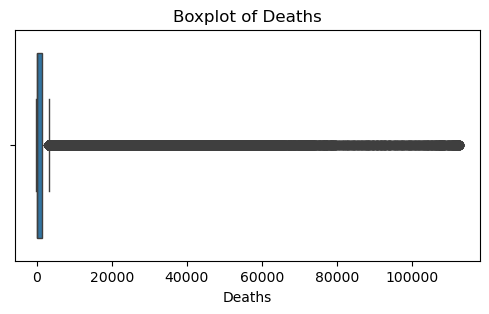

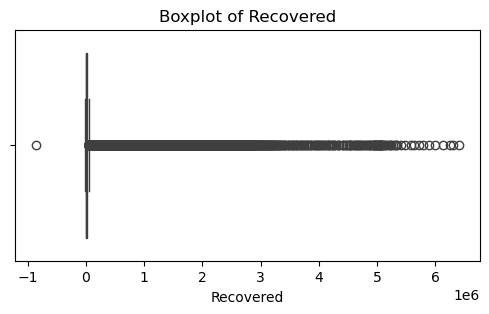

In [31]:
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df_imputed[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [33]:
df_z_removed.isna().sum()

SNo                0
ObservationDate    0
Province/State     0
Country/Region     0
Last Update        0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64

In [ ]:
# Convert Categorical Data to Numerical

In [35]:
cat_cols = df_z_removed.select_dtypes(include='object').columns
print("Categorical columns:\n", cat_cols)

Categorical columns:
 Index(['ObservationDate', 'Province/State', 'Country/Region', 'Last Update'], dtype='object')


In [ ]:
# Method 1: Label Encoding

In [37]:
df_label_encoded = df_z_removed.copy()
le = LabelEncoder()

for col in cat_cols:
    df_label_encoded[col] = le.fit_transform(df_label_encoded[col])

df_label_encoded.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1.0,21,24,126,0,1.0,0.0,0.0
1,2.0,21,60,126,0,14.0,0.0,0.0
2,3.0,21,124,126,0,6.0,0.0,0.0
3,4.0,21,193,126,0,1.0,0.0,0.0
4,5.0,21,199,126,0,0.0,0.0,0.0


In [ ]:
# Method 2: One-Hot Encoding

In [39]:
df_one_hot = pd.get_dummies(df_z_removed, columns=cat_cols, drop_first=True)
df_one_hot = df_one_hot.astype(int)
df_one_hot.head()

,SNo,Confirmed,Deaths,Recovered,ObservationDate_01/02/2021,ObservationDate_01/03/2021,ObservationDate_01/04/2021,ObservationDate_01/05/2021,ObservationDate_01/06/2021,ObservationDate_01/07/2021,...,Last Update_2021-05-25 04:21:08,Last Update_2021-05-26 04:20:35,Last Update_2021-05-27 04:20:59,Last Update_2021-05-28 04:20:36,Last Update_2021-05-29 04:20:41,Last Update_2021-05-30 04:20:55,Last Update_3/8/20 5:31,Last Update_4/2/20 8:53,Last Update_4/4/20 9:38,Last Update_4/6/20 9:37
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df_one_hot = pd.get_dummies(df_z_removed, columns=cat_cols, drop_first=True)
df_one_hot = df_one_hot.astype(int)
print("\n One-hot encoded dataset shape:", df_one_hot.shape)
print("\n Preview of encoded data:")
df_one_hot.head()


 One-hot encoded dataset shape: (298132, 3363)

 Preview of encoded data:


,SNo,Confirmed,Deaths,Recovered,ObservationDate_01/02/2021,ObservationDate_01/03/2021,ObservationDate_01/04/2021,ObservationDate_01/05/2021,ObservationDate_01/06/2021,ObservationDate_01/07/2021,...,Last Update_2021-05-25 04:21:08,Last Update_2021-05-26 04:20:35,Last Update_2021-05-27 04:20:59,Last Update_2021-05-28 04:20:36,Last Update_2021-05-29 04:20:41,Last Update_2021-05-30 04:20:55,Last Update_3/8/20 5:31,Last Update_4/2/20 8:53,Last Update_4/4/20 9:38,Last Update_4/6/20 9:37
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Plot Distributions (EDA)

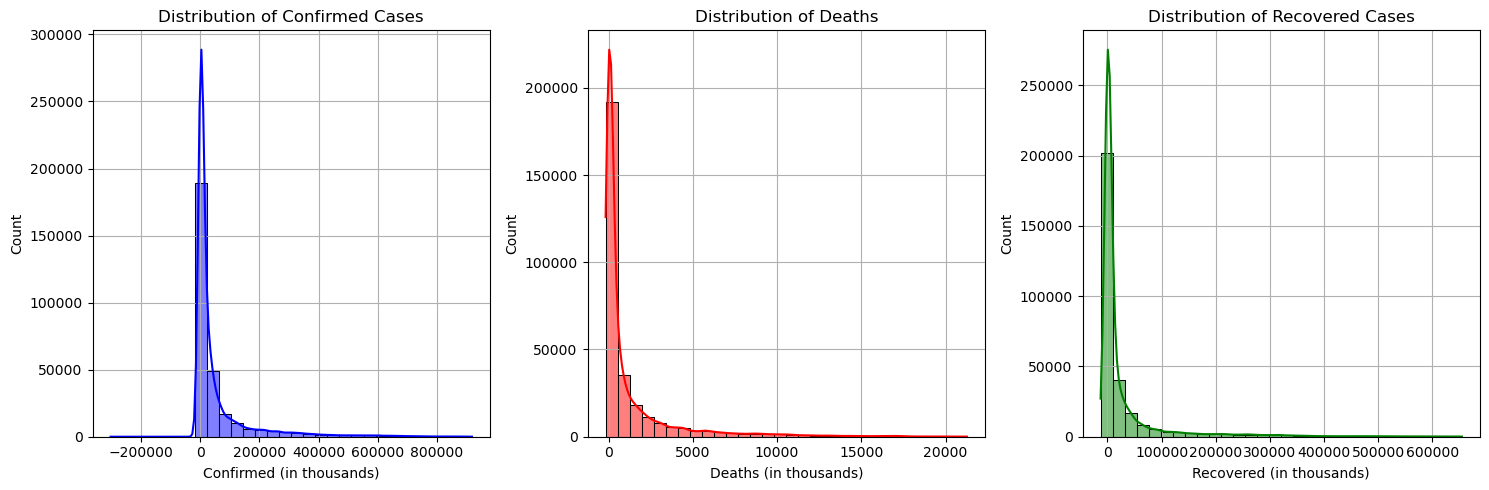

In [71]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df_z_removed['Confirmed'], bins=30, kde=True, color='blue')
plt.title("Distribution of Confirmed Cases")
plt.xlabel("Confirmed (in thousands)")
plt.ylabel("Count")
plt.grid(True)

plt.subplot(1, 3, 2)
sns.histplot(df_z_removed['Deaths'], bins=30, kde=True, color='red')
plt.title("Distribution of Deaths")
plt.xlabel("Deaths (in thousands)")
plt.ylabel("Count")
plt.grid(True)

plt.subplot(1, 3, 3)
sns.histplot(df_z_removed['Recovered'], bins=30, kde=True, color='green')
plt.title("Distribution of Recovered Cases")
plt.xlabel("Recovered (in thousands)")
plt.ylabel("Count")
plt.grid(True)

plt.tight_layout()
plt.show()

C:\Users\Shivprasad\AppData\Local\Temp\ipykernel_25500\3433144227.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Country/Region', data=df_z_removed[df_z_removed['Country/Region'].isin(top_10_countries)], order=top_10_countries, palette='viridis')


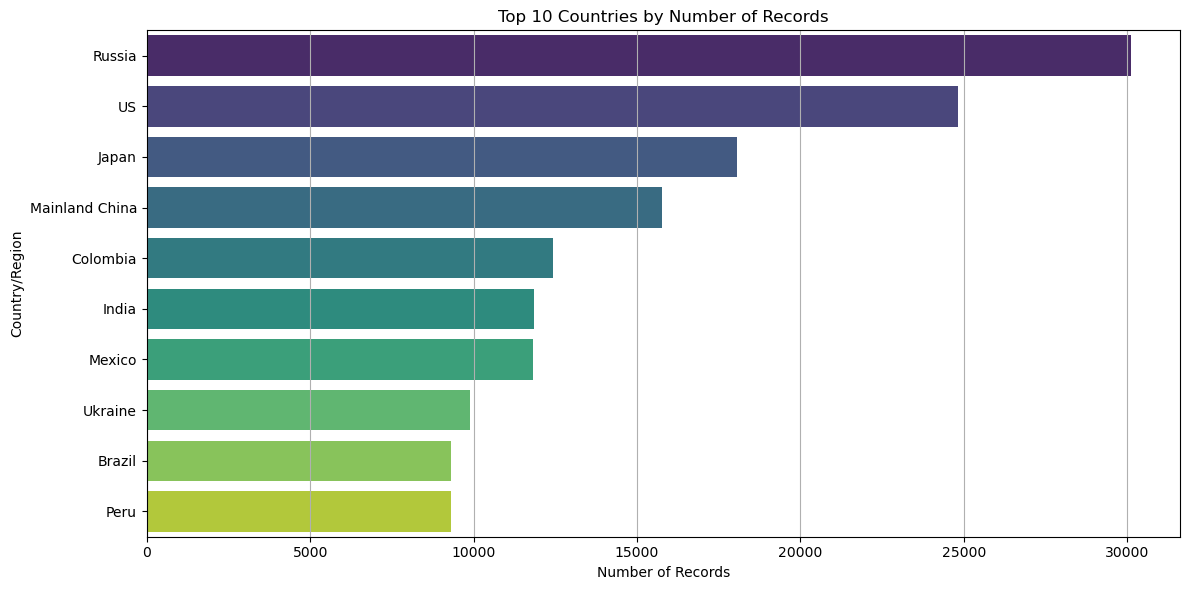

In [73]:
top_10_countries = df_z_removed['Country/Region'].value_counts().nlargest(10).index

plt.figure(figsize=(12, 6))
sns.countplot(y='Country/Region', data=df_z_removed[df_z_removed['Country/Region'].isin(top_10_countries)], order=top_10_countries, palette='viridis')
plt.title('Top 10 Countries by Number of Records')
plt.xlabel('Number of Records')
plt.ylabel('Country/Region')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [ ]:
# Analyze Data Using Correlation (EDA)

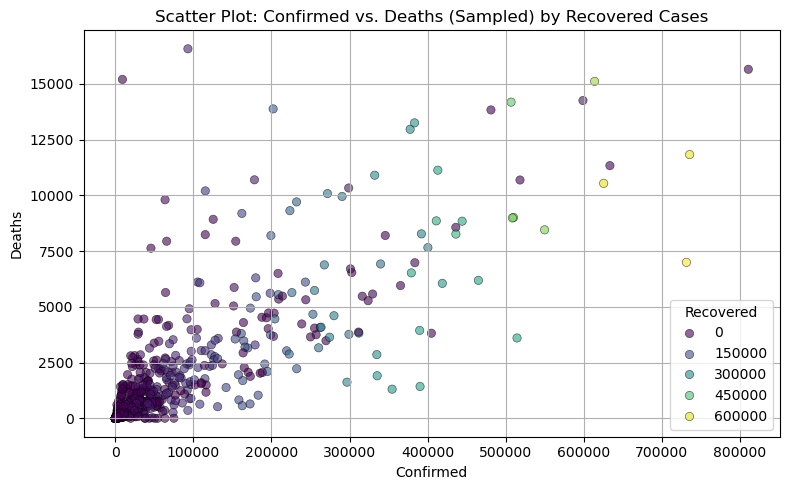

In [75]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df_z_removed.sample(1000, random_state=42),  # 👈 plot a sample (not all rows)
    x='Confirmed',
    y='Deaths',
    hue='Recovered',
    palette='viridis',
    alpha=0.6,
    edgecolor='black'
)
plt.title("Scatter Plot: Confirmed vs. Deaths (Sampled) by Recovered Cases")
plt.xlabel("Confirmed")
plt.ylabel("Deaths")
plt.grid(True)
plt.tight_layout()
plt.show()

In [77]:
# Compute correlation matrix
corr_matrix = df_label_encoded.corr()

# Sort correlations with Confirmed column
target_corr = corr_matrix['Confirmed'].sort_values(ascending=False)

print("🔍 Top correlations with Confirmed:\n")
print(target_corr.head(10))
print("\n🔻 Lowest correlations with Confirmed:\n")
print(target_corr.tail(5))

🔍 Top correlations with Confirmed:

Confirmed          1.000000
Deaths             0.824703
Recovered          0.716452
SNo                0.303681
Last Update        0.076399
Country/Region     0.020794
Province/State    -0.007339
ObservationDate   -0.106272
Name: Confirmed, dtype: float64

🔻 Lowest correlations with Confirmed:

SNo                0.303681
Last Update        0.076399
Country/Region     0.020794
Province/State    -0.007339
ObservationDate   -0.106272
Name: Confirmed, dtype: float64


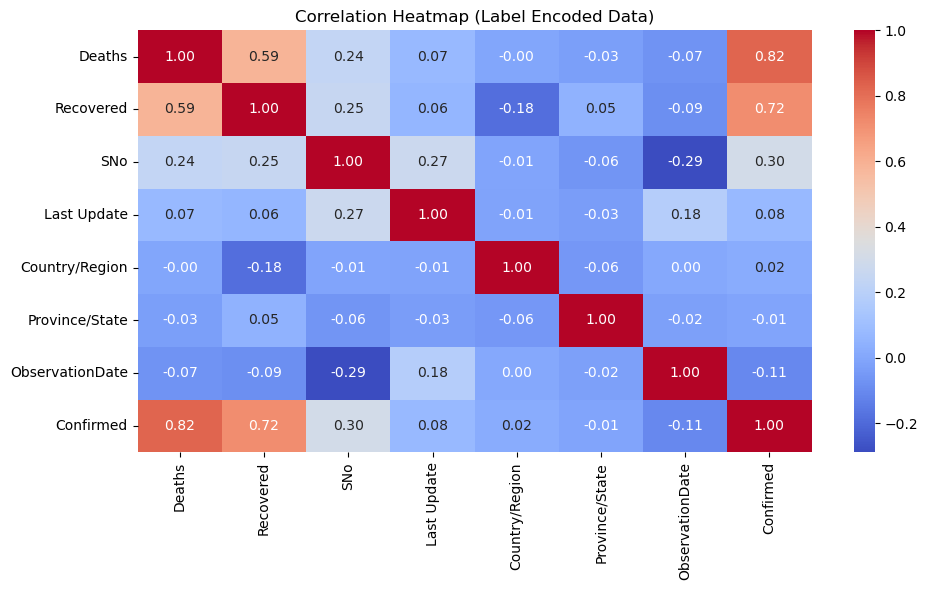

In [79]:
top_corr_features = target_corr[1:11].index.tolist()

plt.figure(figsize=(10, 6))
sns.heatmap(df_label_encoded[top_corr_features + ['Confirmed']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Label Encoded Data)")
plt.tight_layout()
plt.show()

In [ ]:
# Feature Selection
# Method 1: Variance Threshold

In [81]:
# Keep features with variance above 0.01
selector = VarianceThreshold(threshold=0.01)
df_var_selected = selector.fit_transform(df_label_encoded)

# Get selected column names
selected_columns = df_label_encoded.columns[selector.get_support()]
print("✅ Columns retained after Variance Threshold:\n", selected_columns.tolist())

✅ Columns retained after Variance Threshold:
 ['SNo', 'ObservationDate', 'Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered']


In [ ]:
# Method 2: SelectKBest

In [83]:
X = df_label_encoded.drop(columns='Confirmed')  # Features
y = df_label_encoded['Confirmed']               # Target

# Select top 10 features
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

# Show selected features
selected_columns = X.columns[selector.get_support()]
print("✅ Top 10 features selected by SelectKBest:\n", selected_columns.tolist())

C:\Users\Shivprasad\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=7. All the features will be returned.
  warnings.warn(


✅ Top 10 features selected by SelectKBest:
 ['SNo', 'ObservationDate', 'Province/State', 'Country/Region', 'Last Update', 'Deaths', 'Recovered']


In [ ]:
# Method 3: SelectPercentile

In [85]:
selector = SelectPercentile(score_func=f_classif, percentile=20)
X_percentile = selector.fit_transform(X, y)

selected_columns = X.columns[selector.get_support()]
print("✅ Top 20% features selected by SelectPercentile:\n", selected_columns.tolist())

✅ Top 20% features selected by SelectPercentile:
 ['Deaths', 'Recovered']


In [ ]:
# Method 4: Principal Component Analysis (PCA)

In [87]:
# Standardize data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 5 principal components
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

print("Explained Variance by PCA components:")
print(pca.explained_variance_ratio_)

Explained Variance by PCA components:
[0.26566359 0.17031561 0.16360724 0.1423969  0.13334424]
